# How to choose the optimizer for deep learning with Keras: a case study

The purpose of this notebook is to help to develop better intuition about how different optimization algorithms behave on the MNIS and Fashion MNIST datasets.

<img src="https://www.stratio.com/wp-content/uploads/2017/10/4.jpg" 
alt="MNIST data" width="450" height="260" border="1" />

Let's begin the same way we did in TP1 [First step in deep learning with the MNIST data set](
 https://github.com/StephaneCanu/Deep_learning_lecture/blob/master/TP1_MNIST.ipynb)

In [1]:
import keras
import time
import numpy as np
import matplotlib.pyplot as plt

#np.random.seed(42)       
from tensorflow import set_random_seed
#set_random_seed(42)

/Users/stephane/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
#(X_a, y_a), (X_t, y_t) = mnist.load_data()
(X_a, y_a), (X_t, y_t) = fashion_mnist.load_data()


In [3]:
X_a = X_a/255
X_t = X_t/255

x_a = X_a.reshape(60000, 784)  # reshape input from (28,28) to 784
x_t = X_t.reshape(10000, 784)
x_a = x_a.astype('float32')
x_t = x_t.astype('float32')

print(np.shape(X_a))
print(np.shape(x_a))

img_rows, img_cols = 28, 28
X_a = X_a.reshape(X_a.shape[0], img_rows, img_cols, 1)
X_t = X_t.reshape(X_t.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
X_a = X_a.astype('float32')
X_t = X_t.astype('float32')
X_a.shape

(60000, 28, 28)
(60000, 784)


(60000, 28, 28, 1)

In [4]:
num_classes = 10;
Y_a = keras.utils.to_categorical(y_a, num_classes)
Y_t = keras.utils.to_categorical(y_t, num_classes)

Y_a.view()

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [5]:
from sklearn.model_selection import train_test_split
x_a, x_v, Y_a, Y_v = train_test_split(x_a, Y_a, test_size=1/6, random_state=42)

print(np.shape(x_a))
print(np.shape(x_v))

(50000, 784)
(10000, 784)


We start with a simple fully conected network with a single hidden layer of 300 neurons.

In [6]:
from keras.models import Sequential
from keras.layers import Dense

def my_NN(opt,ep,bs):
 # Build the neural network   
    NN = Sequential()
    NN.add(Dense(units=300, activation='tanh', input_dim=784))
    NN.add(Dense(units=10, activation='softmax'))
    NN.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
# Train    
    t0=time.time()
    h = NN.fit(x_a, Y_a, batch_size=bs, epochs=ep, verbose=0, validation_data=(x_v,Y_v))
    t = time.time()-t0
# Evaluate    
    score = NN.evaluate(x_t, Y_t)  
    err = 100*(1-np.array(score))
    del NN
    
    return err[1], score[0], t, h

Let's start by training a simple fully conected network, using a stochastic gradient with the default settings. It takes 5 minutes to train it during 100 epoch.

10000/10000 [==============================] - 0s 23us/step
Test err:  12.12 %  time: 4.67 min


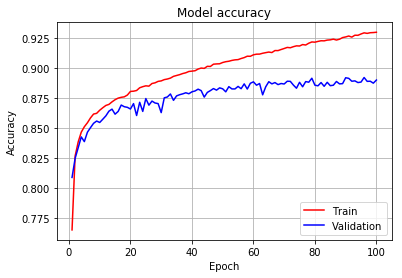

In [7]:
er, sc, tn, history = my_NN(keras.optimizers.SGD(),100,32)
print('Test err:  %4.2f %%  time: %4.2f min'% (er,tn/60))
plt.plot(list(range(1,len(history.history['val_acc'])+1)),history.history['acc'],'r')
plt.plot(list(range(1,len(history.history['val_acc'])+1)),history.history['val_acc'],'b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(('Train', 'Validation', 'Test'), loc='lower right')
plt.grid()
plt.show()

As epoch goes by, the traininng accuracy improves while the validation error seems to reach a plateau.
However, because of the randomness of the stochastic gradient, the value of the validation error shows oscillations preventing from  any precise interpretation.  

A first idea to stabilize the validation error is to increase the mini batch size, for instance from 32 to 256. 
Acording to  [Masters & Luschi](https://arxiv.org/abs/1804.07612), it is a good idea to review learning curves of model validation error against training time with different batch sizes when tuning the batch size.

10000/10000 [==============================] - 0s 24us/step
Test err:  14.59 %  time: 1.45 min


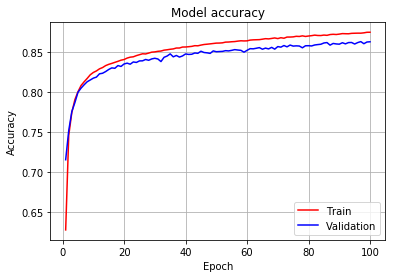

In [8]:
er, sc, tn, history = my_NN(keras.optimizers.SGD(),100,256)
print('Test err:  %4.2f %%  time: %4.2f min'% (er,tn/60))
plt.plot(list(range(1,len(history.history['val_acc'])+1)),history.history['acc'],'r')
plt.plot(list(range(1,len(history.history['val_acc'])+1)),history.history['val_acc'],'b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(('Train', 'Validation', 'Test'), loc='lower right')
plt.grid()
plt.show()

Ok, the validation accuracy is stabilized but at a lower level. This is not this is not satisfactory.

Another way to stabilize the results is to avarage the results overs $k=10$  different tries, randomizing over the initialization of the network parameters and the order in which the examples are chosen to provide mini-batch. It will take about one hiur and a half.

10000/10000 [==============================] - 0s 23us/step
Test err:  11.62 %  time: 8.62 min
10000/10000 [==============================] - 0s 23us/step
Test err:  11.84 %  time: 9.05 min
10000/10000 [==============================] - 0s 23us/step
Test err:  12.72 %  time: 9.22 min
10000/10000 [==============================] - 0s 24us/step
Test err:  11.32 %  time: 9.57 min
10000/10000 [==============================] - 0s 23us/step
Test err:  11.75 %  time: 9.92 min
10000/10000 [==============================] - 0s 23us/step
Test err:  11.36 %  time: 9.66 min
10000/10000 [==============================] - 0s 24us/step
Test err:  11.14 %  time: 9.45 min
10000/10000 [==============================] - 0s 23us/step
Test err:  11.26 %  time: 9.71 min
10000/10000 [==============================] - 0s 29us/step
Test err:  11.31 %  time: 10.01 min
10000/10000 [==============================] - 0s 25us/step
Test err:  11.35 %  time: 10.38 min


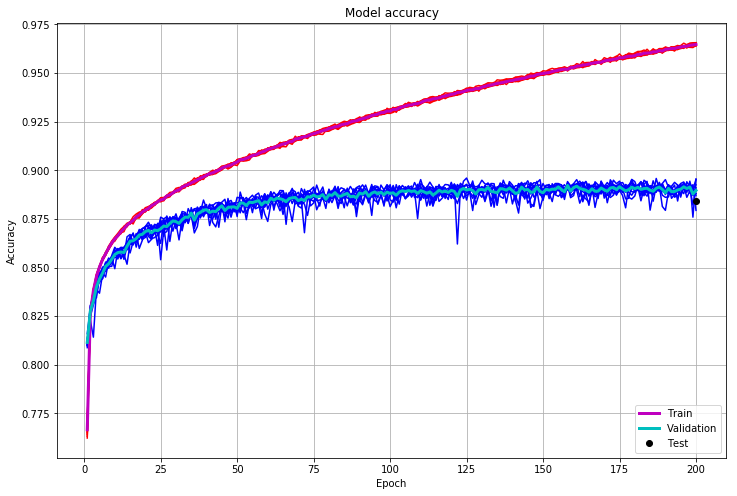

In [9]:
Er = 0
k = 10
e_a = 0
e_v = 0
     
plt.figure(figsize=(12,8))
for i in range(k) :
    er, sc, tn, history = my_NN(keras.optimizers.SGD(),200,32)
    print('Test err:  %4.2f %%  time: %4.2f min'% (er,tn/60))
    Er = Er + er;
    plt.plot(list(range(1,len(history.history['val_acc'])+1)),history.history['acc'],'r')
    plt.plot(list(range(1,len(history.history['val_acc'])+1)),history.history['val_acc'],'b')
    e_a = e_a + np.asarray(history.history['acc'])
    e_v = e_v + np.asarray(history.history['val_acc'])

l1, = plt.plot(list(range(1,len(history.history['val_acc'])+1)),e_a/k,'m', linewidth=3)
l2, = plt.plot(list(range(1,len(history.history['val_acc'])+1)),e_v/k,'c', linewidth=3)
l3, = plt.plot(len(history.history['val_acc']),(100-Er/k)/100,'ok')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend((l1,l2,l3),('Train', 'Validation', 'Test'), loc='lower right')
plt.grid()
plt.show()

The validation error stabilises but it get stuck on a plateau region. And we pay the price in terms of computing time. Furthermore, the test accuracy (black spot) is close to the validation, but a little bit below indicating a tendency to over-learning to be monitored.

Now we are going to compare [all the optimizer proposed by Keras](https://keras.io/optimizers/), mostly with defaul parameter value. The batch size is 32, we average over  5 times and we perform only 50 epoch. All together, it takes about 3 hours with a CPU. This could have been computed in about 5 minutes if distributed over 60 CPU.

In [10]:
list_opt = [
keras.optimizers.SGD(),
keras.optimizers.SGD(lr=0.01, clipnorm=1., clipvalue=0.5),
keras.optimizers.SGD(lr=0.01, nesterov=True),
keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False),
keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True),
keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0),
keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)   
]

list_opt_txt = [
'SGD',
'SGD cliping',
'SGD Nesterov',
'SGD WD+momentum',
'SGD +nesterov)',
'Adam',
'Amsgrad',
'Adamax',
'Nadam',
'RMSprop',
'Adagrad',
'Adadelta'   
]

k = 5
l = 0
plt.figure(figsize=(12,8))
for opt in list_opt:
    e_v = 0
    Er = 0
    print(list_opt_txt[l])
    l = l+1
    
    for i in range(k) :
       er, sc, tn, history = my_NN(opt,50,32)
       print('Test err:  %4.2f %%  time: %4.2f min'% (er,tn/60))
       e_v = e_v + np.asarray(history.history['val_acc'])
       Er = Er + er;

    print('Mean test err:  %4.2f %%  '% (Er/k))
    plt.plot(list(range(1,len(history.history['val_acc'])+1)),e_v/k)

SGD
10000/10000 [==============================] - 0s 28us/step
Test err:  12.58 %  time: 2.71 min
10000/10000 [==============================] - 0s 26us/step
Test err:  12.87 %  time: 2.65 min
10000/10000 [==============================] - 0s 26us/step
Test err:  12.92 %  time: 2.69 min
10000/10000 [==============================] - 0s 26us/step
Test err:  12.80 %  time: 2.71 min
10000/10000 [==============================] - 0s 26us/step
Test err:  12.57 %  time: 2.69 min
Mean test err:  12.75 %  
SGD cliping
10000/10000 [==============================] - 0s 28us/step
Test err:  13.42 %  time: 2.92 min
10000/10000 [==============================] - 0s 30us/step
Test err:  13.58 %  time: 3.09 min
10000/10000 [==============================] - 0s 28us/step
Test err:  13.20 %  time: 3.12 min
10000/10000 [==============================] - 0s 28us/step
Test err:  13.33 %  time: 3.17 min
10000/10000 [==============================] - 0s 27us/step
Test err:  13.38 %  time: 3.22 min
Mean tes

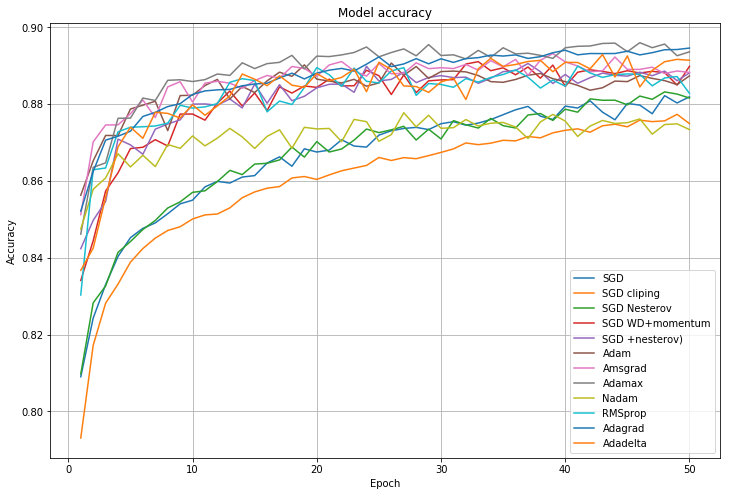

In [11]:
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(list_opt_txt)
plt.grid()
plt.show()

Results are not so clear because of the remaining oscilation and because of the use of the default parameter. Netherthelass, results indicates that Adamax (in grey) Adagrad (in blue), and Adadelta (in orange) are preferible, outperforming the SGD even after 200 epoch. Note that Adamax is two time slower the SGD. Still, [some articles advocate the use of SDG](http://papers.nips.cc/paper/7003-the-marginal-value-of-adaptive-gradient-methods-in-machine-learning). All other optimizers look comparable.

There exists many other adaptive learning rate methods to be tested such as in https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1.

The following table presents some parameters of a neural network training and possible settings (some are default Keras parameter values).

----------------------------------------------------
|Name          |Range                   | Default value|
|:-------------|:-----------------------|:-------------|
|Learning rate |0.1, 0.01, 0.001, 0.0001| 0.01         |
|Batch size    |32, 64, 128, 256        |32           |
|Momentum rate |0.8, 0.9, 0.95          | 0.9          |
|Weight initialization| Normal, Uniform, Glorot uniform |Glorot uniform |
|learning rate | 0.1 0.01 0.001 | 0.01 |
|Optimizer     |RMSprop, Adagrad, Adadelta, Adam |Adadelta |
|Batch normalization | Yes, no          | Yes  |
|Learning rate decay |None, Linear, Exponential |Linear (rate 0.5)|
|Activation function |Sigmoid, Tanh, ReLU, Softmax |ReLU |
|Dropout rate | 0.1, 0.25, 0.5, 0.75 | 0.5|
|L1, L2 regularization | 0, 0.01, 0.001| |